In [236]:
# imports
import numpy as np
import scipy as sp
from scipy.integrate import odeint
import matplotlib
from matplotlib import gridspec
%matplotlib inline
import pylab as pl

# define some settings for plots
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['font.family'] = ['sans-serif']

line_width = 2
color_rna = 'dodgerblue'
color_protein = 'darkorange'
color_phase_space = 'dimgrey'
color_initial_state = 'crimson'
color_steady_state = 'saddlebrown'

# Introduction

Write some intro here

# Simple transcription-translation system modeled by a deterministic ODE system

## Biochemical reactions

In a simple transcription-translation system the RNA of a certain gene is prodcued with a fixed rate $\beta$ and decays with a rate proportional to the curren amount of RNA, a so called first order decay. The protein that our gene is coding for is produced with a rate that is proportional to the current amount of RNA and follows a first order decay as well. A reaction scheme of this small system looks like this:

$$\xrightarrow{\beta} RNA \xrightarrow{\gamma_{m}} o$$ $$RNA \xrightarrow{k} protein$$ $$protein \xrightarrow{\gamma_{p}} o$$

## Deterministic ODE system

The above reaction scheme can be tranlated into two [differential equations](https://en.wikipedia.org/wiki/Differential_equation). For the sake of simplicity we have assumed [mass action kinetics](https://en.wikipedia.org/wiki/Law_of_mass_action) without any saturation effects.

$$ \frac{\mathrm{d}RNA}{\mathrm{d}t} = \beta - \gamma_{m}\cdot RNA$$ 

$$ \frac{\mathrm{d}protein}{\mathrm{d}t} = k\cdot RNA - \gamma_{p} \cdot protein$$

This system of equations describes the rule how the systems state given by the concentration of RNA and protein molecules changes given the current state. The left hand side of the equations are the rate of change and the right hand side the rule how the change depends on the current state. Note that the concentration of RNA appears in both equations, thus the equations are coupled as the amount of proteins depends on the amount of RNA.

To explicitly solve ODEs it is necessary to know the state of the system at one instant of time. Often refered to as the intial conditions and associated with time point $t = 0$. 

We assumed the transcription rate $\beta$ to be constant over time. You can imagine this situation as if at time point zero a transcription factor binds the gene's promoter and activates transcription. For now we will investigate the temporal evolution of the RNA and protein assuming constant transcription, later we will consider the case when transcription is only transiently activated.

### Steady state

The transcription-translation reaches a steady state, i.e. RNA and protein concentrations that do not change over time because the respective production and decay processes balance each other. In steady state the left hand side of the differential equations equals zero and we are left with two algebraic equations that we can solve to calculate the steady state:

$$RNA_{ss} = \frac{\beta}{\gamma_{m}}$$

$$P_{ss} = \frac{k\cdot RNA_{ss}}{\gamma_{p}} = \frac{k\beta}{\gamma_{m}\gamma_{p}}$$

The steady state is fully determined by the biochemical reaction rates of our system and it is a stable state. This means if we move the system out of steady state it will return.

## Analytic solution

The solution of the ODE system with the intital condition $RNA_{0} = protein_{0} = 0$ is given by:

$$ \text{RNA}(t)= RNA_{ss}\big( 1- e^{-\gamma_{m} t}\big)$$

$$\text{protein}(t)= P_{ss}\bigg(1 - \frac{\gamma_{m}e^{-\gamma_{p}t} - \gamma_{m}e^{-\gamma_{p}t}}{\gamma_{m} - \gamma_{p}}\bigg)$$

For the simple ODE system given here it is possible to obtain a analytical solution, in more complex situations this usually is not possible and it is necessary to numerically integrate differential equations. Although we could work here with the analytical solutions we want to go the numerical way. A first impression on how an algorithm could approximate a solution of an ODE gives [Euler method](https://en.wikipedia.org/wiki/Euler_method).

In [3]:
# functions

# numerical solution of the ODE system
def solve_ODE_transcription_translation(x,t,param):
    RNA = x[0]
    protein = x[1]
    
    dRNA = param[0] - param[1]*RNA
    dprotein = param[2]*RNA - param[3]*protein
    
    return np.hstack((dRNA,dprotein))

# analytical solution based on the equations above
def analytic_solution(tt,param):
    RNA = param[0]/param[1]*(1 - sp.exp(-param[1]*tt))
    p_ss = param[0]/param[1]*param[2]/param[3]
    protein = p_ss*(1 - (param[1]*sp.exp(-param[3]*tt) - param[3]*sp.exp(-param[1]*tt))/(param[1] - param[3]))
    
    res = np.vstack((RNA,protein))
    
    return res

(-0.3, 11.0)

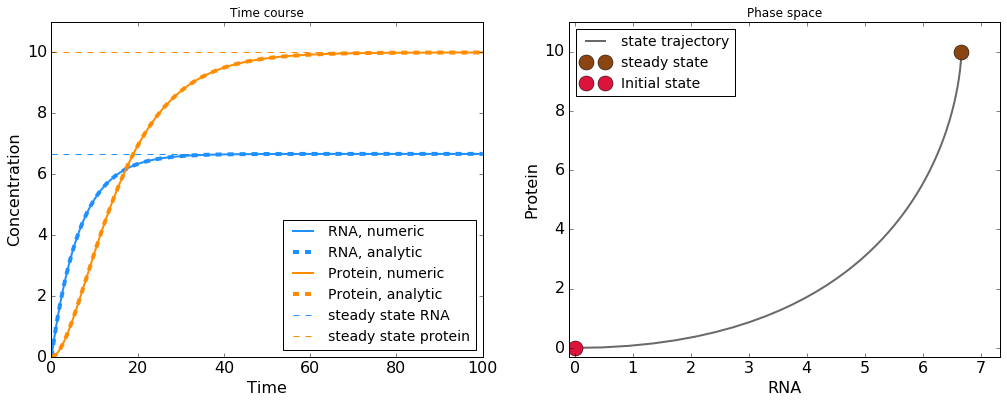

In [137]:
# define parameters and time vector to solve the ODEs
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 0
protein_0 = 0
y_0 = [RNA_0,protein_0]

# set the time vector
tt = sp.linspace(0,100,200)

# solve the ODE system with the defined parameters and initial condition
sol_deterministic = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))

# calculate the analytic solution
analytic = analytic_solution(tt,param)

# plot the result
fig,ax = pl.subplots(1,2, figsize = (17,6))
ax[0].plot(tt,sol_deterministic[:,0], label = 'RNA, numeric', lw = line_width,color = color_rna)
ax[0].plot(tt,analytic[0],'--',lw = 2*line_width, color = color_rna, label = 'RNA, analytic')
ax[0].plot(tt,sol_deterministic[:,1], label = 'Protein, numeric', lw = line_width, color = color_protein)
ax[0].plot(tt,analytic[1],'--',lw = 2*line_width, color = color_protein, label = 'Protein, analytic')
ax[0].plot(tt,np.zeros(len(tt)) + steady_state_RNA,'--',color = color_rna,label = 'steady state RNA')
ax[0].plot(tt,np.zeros(len(tt)) + steady_state_protein,'--',color = color_protein, label = 'steady state protein')
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[0].set_title('Time course')
ax[0].set_ylim(0,steady_state_protein+steady_state_protein*0.1)

ax[1].plot(sol_deterministic[:,0],sol_deterministic[:,1], color = color_phase_space,lw = line_width, 
           label = 'state trajectory')
ax[1].plot(steady_state_RNA,steady_state_protein,'o',ms = 15,label = 'steady state', color = color_steady_state)
ax[1].plot(RNA_0,protein_0,'o',ms = 15,label = 'Initial state', color = color_initial_state)
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')
ax[1].set_xlim(-0.1,steady_state_RNA+steady_state_RNA*0.1)
ax[1].set_ylim(-0.3,steady_state_protein+steady_state_protein*0.1)

## Influence of the RNA and protein decay rates on the time to reach the steady state

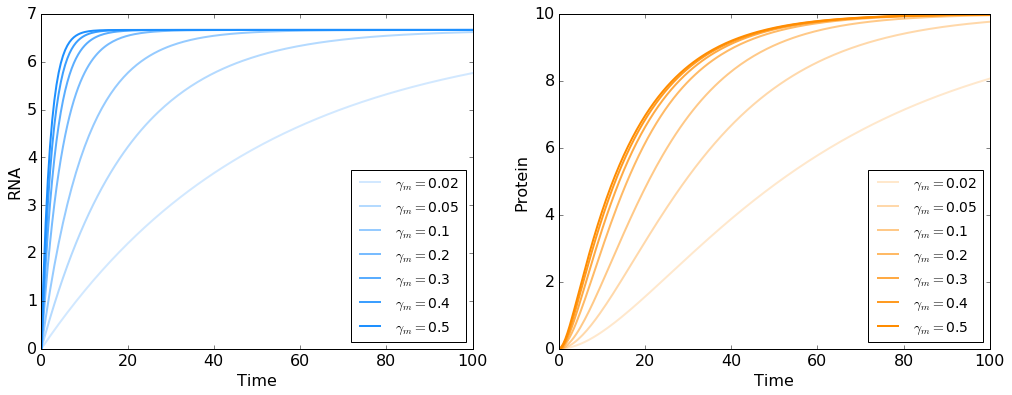

In [15]:
# range of decay rates of the RNA
GAMMA_m = np.array([0.02,0.05,0.1,0.2,0.3,0.4,0.5])
beta = steady_state_RNA * GAMMA_m

k = 0.1
gamma_p = k * steady_state_RNA / steady_state_protein

# iterate over the defined decay rates
sol = []
for ii,gamma_m in enumerate(GAMMA_m):
    param = [beta[ii],gamma_m,k,gamma_p]
    s = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))
    sol.append(s)
    
# plot results
fig,ax = pl.subplots(1,2,figsize = (17,6))
alpha = sp.linspace(0.2,1,len(sol))
for ii,ss in enumerate(sol):
    ax[0].plot(tt,ss[:,0],lw = line_width, color = color_rna, alpha = alpha[ii], 
               label = '$\gamma_{m} = $'+str(GAMMA_m[ii]))
    
    ax[1].plot(tt,ss[:,1],lw = line_width, color = color_protein, alpha = alpha[ii], 
               label = '$\gamma_{m} = $'+str(GAMMA_m[ii]))

ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('RNA')

ax[1].legend(loc = 'best')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Protein')

The time to reach half steady state provides a measure for the response time of the system. Four our system of two ODEs this time can be analytically calculated from the solutions of the ODEs by setting the right hand side to $RNA_{ss}/2$ and $P_{ss}/2$ and solving for the respective decay rates. The response time of the RNA depends only on RNA decay and can be calculated as:

$$\tau_{1/2, RNA} = \frac{\ln 2}{\gamma_{m}}$$

As the plots above indicate the response time of the protein depends on both decay rates $\gamma_{m}$ and $\gamma_{p}$.

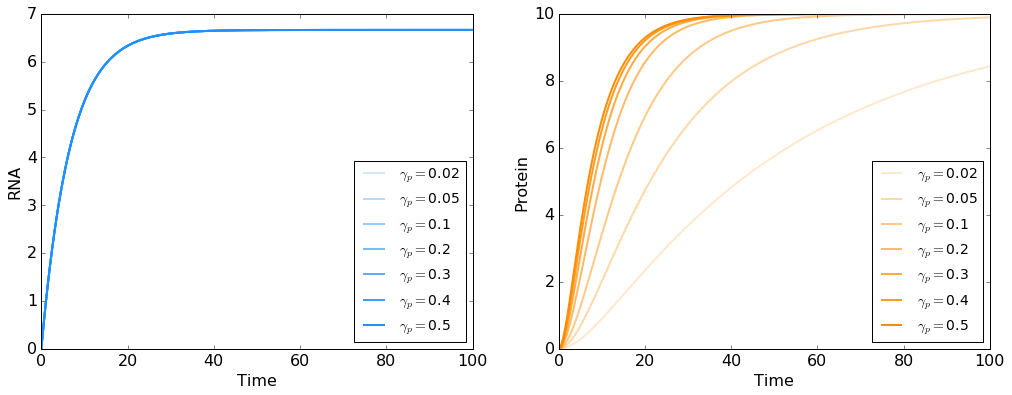

In [21]:
# range of protein decay rates
GAMMA_p = np.array([0.02,0.05,0.1,0.2,0.3,0.4,0.5])
k = GAMMA_p * steady_state_protein / steady_state_RNA

beta = 1
gamma_m = 0.15

sol = []
for ii,gamma_p in enumerate(GAMMA_p):
    param = [beta,gamma_m,k[ii],gamma_p]
    s = odeint(solve_ODE_transcription_translation,y_0,tt,args = (param,))
    sol.append(s)
    
# plot results
fig,ax = pl.subplots(1,2,figsize = (17,6))
alpha = sp.linspace(0.2,1,len(sol))
for ii,ss in enumerate(sol):
    ax[0].plot(tt,ss[:,0],lw = line_width, color = color_rna, alpha = alpha[ii], 
               label = '$\gamma_{p} = $'+str(GAMMA_m[ii]))
    
    ax[1].plot(tt,ss[:,1],lw = line_width, color = color_protein, alpha = alpha[ii], 
               label = '$\gamma_{p} = $'+str(GAMMA_m[ii]))

ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('RNA')

ax[1].legend(loc = 'best')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Protein')

## Transient activation of gene transcription

Now we will investigate the case when gene transcription is only transiently activated by a transcription factor. The biological scenario is that the transcription factor remains at the promoter only for a certain amount of time. Mathematically this means that the transcription rate is a function of time $\beta = \beta(t)$. We assume the functional relation for $\beta$ to be the sum of two sigmoidal functions:

$$\beta(t) = \beta\bigg(\frac{1}{1 + e^{-k_{up}(t - \tau_{up})}} - \frac{1}{1 + e^{-k_{down}(t - \tau_{down})}}\bigg)$$

In [99]:
# functions
def TF_binding(param,tt):
    k_up,k_down,on,off = param[0],param[1],param[2],param[3]

    up = 1./(1 + sp.exp(-k_up*(tt-on)))
    down = - 1./(1 + sp.exp(-k_down*(tt-off)))
    binding = (up + down)
    
    return binding

# ODE system with time varying transcription rate
def solve_ODE_time_dependent_transcription(x,t,param,param_binding):
    RNA = x[0]
    protein = x[1]
    
    dRNA = param[0]*TF_binding(param_binding,t) - param[1]*RNA
    dprotein = param[2]*RNA - param[3]*protein
    
    return np.hstack((dRNA,dprotein))

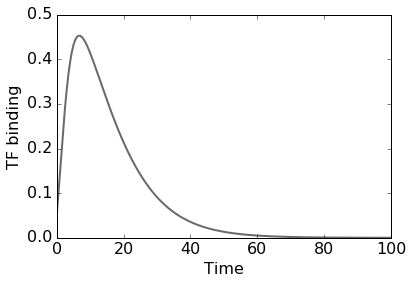

In [100]:
# visualize the TF binding pattern
k_up = 0.5
k_down = 0.1
on = 1
off = 7
beta = 1
param_binding = [k_up,k_down,on,off]
binding = beta*TF_binding(param_binding,tt)

fig,ax = pl.subplots(1,1, figsize = (6,4))
ax.plot(tt,binding, lw = line_width, color = color_phase_space)
ax.set_ylabel('TF binding')
ax.set_xlabel('Time')

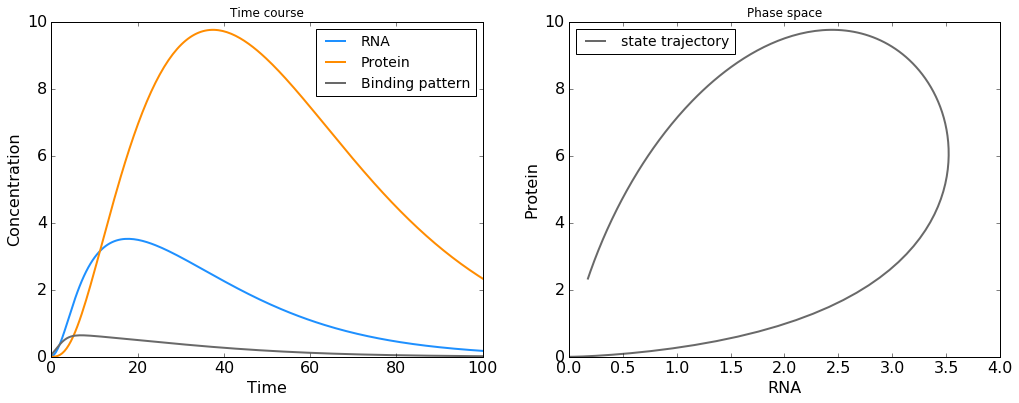

In [119]:
# define parameters and time vector to solve the ODEs
beta = 1
gamma_m = 0.15
k = 0.2
gamma_p = 0.05
param = [beta,gamma_m,k,gamma_p]

# define the binding pattern
k_up = 0.7
k_down = 0.05
on = 1
off = 20
param_binding = [k_up,k_down,on,off]

binding = beta*TF_binding(param_binding,tt)

# solve the ODE system
sol = odeint(solve_ODE_time_dependent_transcription,y_0,tt,args = (param,param_binding))
 
# plot the result
fig,ax = pl.subplots(1,2, figsize = (17,6))
ax[0].plot(tt,sol[:,0], label = 'RNA', lw = line_width,color = color_rna)
ax[0].plot(tt,sol[:,1], label = 'Protein', lw = line_width, color = color_protein)
ax[0].plot(tt,binding,lw = line_width,color = color_phase_space,label = 'Binding pattern')
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Concentration')
ax[0].set_title('Time course')
# ax[0].set_ylim(0,steady_state_protein+steady_state_protein*0.1)

ax[1].plot(sol[:,0],sol[:,1], color = color_phase_space,lw = line_width, label = 'state trajectory')
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')
# ax[1].set_xlim(-0.1,steady_state_RNA+steady_state_RNA*0.1)
# ax[1].set_ylim(-0.3,steady_state_protein+steady_state_protein*0.1)

# Transcription-translation system modeled as stochastic system: single cell behaviour

## The stochastic simulation algorithm

Developed mainly by Daniel Gillespie. The algorithm simulates the stochastic biochemical interactions of the reacting species, here RNA and protein, based on the current amount molecules of each species and the rates of the possible reactions. The algorithm essentially is a loop and in each iteration the next reaction that happens and the time point of the reaction are simulated based on random number generation. A deeper explanation of the algorithm can be found on [wikipedia](https://en.wikipedia.org/wiki/Gillespie_algorithm) or in the original publications of [D. Gillespie](http://pubs.acs.org/doi/abs/10.1021/j100540a008). [Here](https://www.ncbi.nlm.nih.gov/pubmed/17037977) you can find a comprehensible review of the algorithm, it's foundations and possible approximate implementations.

In contrast to the deterministic ODE system above the amount of RNA and protein now is not measured in concentrations but in the number of molecules of each species. The systems state is defined by the set of molecule counts. During each iteration of the algorithm the systems state is update according to the sampled reaction.

The system consists of four different reactions:

1. **RNA production:** $ RNA \xrightarrow{\beta} RNA + 1$
2. **RNA decay:** $RNA \xrightarrow{\gamma_{m}\cdot RNA} RNA - 1$
3. **Protein production:** $protein \xrightarrow{k\cdot RNA} protein + 1$
4. **Protein decay:** $protein \xrightarrow{\gamma_{p}\cdot protein} protein - 1$

The likelihood of each reaction depends of the current state of the system, i.e. the number of present RNA and protein molecules.

The **steady state** of the stochastic system is the same as for the deterministic ODE system. However, now we will observe fluctuations around the steady state. The characteristics of this fluctuations are controlled by the reaction rates. Time course measurements of fluctuations around the steady state allow to estimate the kinetic reaction rates which would not be for the ODE system.

In [210]:
# implementation of the Gillespie algorithm to simulate the stochastic transcription-tranlsation system
def stoch_sim_transcription_translation(param,initial_state,tf):
    beta,gamma_m,k,gamma_p = param[0],param[1],param[2],param[3]
    
    # reaction matrix, the systems state includes the time points of the reactions in the first column
    reactions = np.array([[0,1,0],
                         [0,-1,0],
                         [0,0,1],
                         [0,0,-1]])
    
    # initialise the systems state
    state = np.zeros(3)
    state[1] = initial_state[0]
    state[2] = initial_state[1]
    STATE = state
    
    tt = 0
    while tt <= tf:
        # sample two random numbers uniformly between 0 and 1
        rr = sp.random.uniform(0,1,2)
        
        a_0 = beta + gamma_m*state[1] + k*state[1] + gamma_p*state[2]    
        a_s = np.array([beta,gamma_m*state[1],k*state[1],gamma_p*state[2]],dtype = float)
        
        if a_0<0:
            print a_0
            print a_s
            
        # time step 
        tt = tt + 1. / a_0 * sp.log(1. / rr[0])
        state[0] = tt
        
        # find the next reaction
        prop = rr[1] * a_0
        cum_a_s = np.cumsum(a_s)
        
        ind = np.where(prop <= cum_a_s)[0][0]
        
        # update the systems state
        state = state+reactions[ind]
        
        STATE = np.vstack((STATE,state))
    
    return STATE

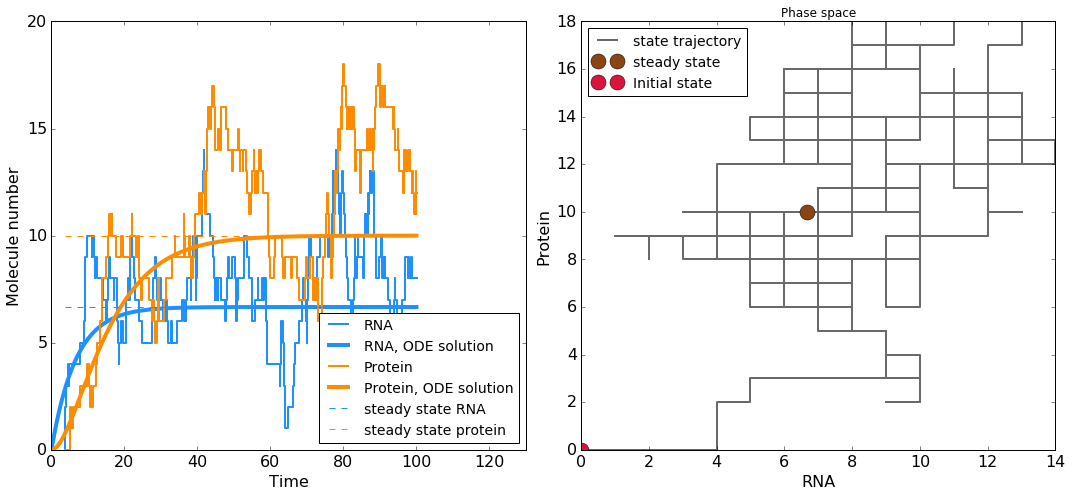

In [234]:
# define parameters and time vector to solve the ODEs
beta = 1
gamma_m = 0.15
k = 0.15
gamma_p = 0.1
param = [beta,gamma_m,k,gamma_p]

# calculate steady state
steady_state_RNA = beta/gamma_m
steady_state_protein = k*beta/gamma_m/gamma_p

# define intial conditions
RNA_0 = 0
protein_0 = 0
initial_state = [RNA_0,protein_0]

# simulation time
tf = 100

sim = stoch_sim_transcription_translation(param,initial_state,tf)

fig,ax = pl.subplots(1,2, figsize = (15,7))
ax[0].plot(sim[:,0],sim[:,1], label = 'RNA', color = color_rna, lw = line_width,drawstyle = 'steps')
ax[0].plot(tt,sol_deterministic[:,0], color = color_rna, lw = 2*line_width, label = 'RNA, ODE solution')
ax[0].plot(sim[:,0],sim[:,2], label = 'Protein', color = color_protein,lw = line_width,drawstyle = 'steps')
ax[0].plot(tt,sol_deterministic[:,1], color = color_protein, lw = 2*line_width, label = 'Protein, ODE solution')
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_RNA,'--', label = 'steady state RNA',
          color = color_rna)
ax[0].plot(sim[:,0],np.zeros(len(sim[:,0])) + steady_state_protein,'--', label = 'steady state protein',
          color = color_protein)
ax[0].legend(loc = 'best')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Molecule number')
ax[0].set_ylim(0,2*steady_state_protein)
ax[0].set_xlim(0,130)

ax[1].plot(sim[:,1],sim[:,2], label = 'state trajectory', lw = line_width,color = color_phase_space)
ax[1].plot(steady_state_RNA,steady_state_protein,'o',ms = 15,label = 'steady state', color = color_steady_state)
ax[1].plot(RNA_0,protein_0,'o',ms = 15,label = 'Initial state', color = color_initial_state)
ax[1].legend(loc = 'best')
ax[1].set_ylabel('Protein')
ax[1].set_xlabel('RNA')
ax[1].set_title('Phase space')

pl.tight_layout()

## Influence of the RNA decay rate on temporal fluctuations

We will run stochastic simulations of the fluctuations around steady state and test the influence of the decay rates of RNA and protein while keeping the steady state constant. First lets start with the influence of the decay rate of the RNA. We define a range of RNA decay rates $\gamma_{m}$ and keep the RNA steady state fixed by adjusting the RNA production rate.

In [285]:
# define kinetic parameters
steady_state_RNA = 10
steady_state_protein = 20

# range of decay rates of the RNA
GAMMA_m = np.array([0.01,0.05,0.1,0.5])
beta = steady_state_RNA * GAMMA_m

gamma_p = k * steady_state_RNA / steady_state_protein

k = 0.2

# set the inital conditions to the steady state
initial_state = np.round([steady_state_RNA,steady_state_protein])

# set the simulation time longer than before for better statistics
tf = 500

# iteration over the defined gamma_m
res = []
for ii,gamma_m in enumerate(GAMMA_m):
    param = [beta[ii],gamma_m,k,gamma_p]
    sim = stoch_sim_transcription_translation(param,initial_state,tf)
    
    res.append(sim)

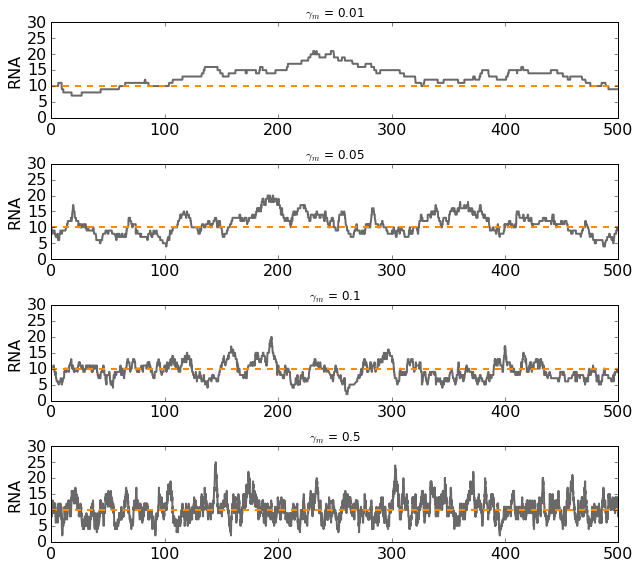

In [287]:
# visualize the results
fig,ax = pl.subplots(len(res),1, figsize = (9,8))

color = 'dimgrey'
color_ss = 'darkorange'
xmin,xmax = 0,tf
ymin_m,ymax_m = 0,30
ymin_p,ymax_p = 0,40

for ii,rr in enumerate(res):
    ax[ii].plot(rr[:,0],rr[:,1],color = color, lw = 2,
               label = '$\gamma_{m}$ = '+str(GAMMA_m[ii]))
    ax[ii].plot([0,tf],[steady_state_RNA,steady_state_RNA],'--',lw = 2, color = color_ss)
    ax[ii].set_ylim(ymin_m,ymax_m)
    ax[ii].set_xlim(xmin,xmax)
    ax[ii].set_ylabel('RNA')
    ax[ii].set_title('$\gamma_{m}$ = '+str(GAMMA_m[ii]))
    
pl.tight_layout()

# Gene expression noise depends on transcription and translation rates

Due to the stochastic nature of biochemical reactions noise in the expression level of proteins is inherent. The noise level can be tuned by a cell by controlling the transcription and translation rates of a gene. On our simple we want to exemplify the effects on two examples:

1. High transcription rate and low tranlation rate
2. Low transcription rate and High translation rate

The steady state protein level for both cases is the same the fluctuations around it are very different. 

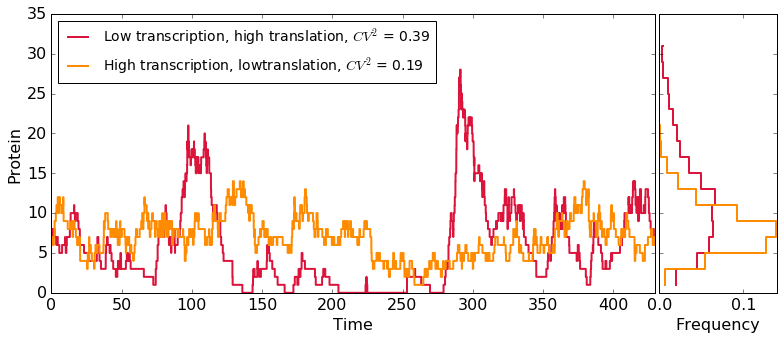

In [292]:
# define high and low transcripion and translation rates
k_low = 0.1
k_high = 1

beta_low = 0.1
beta_high = 1

gamma_m = 0.15
gamma_p = 0.1

param_beta_low = [beta_low,gamma_m,k_high,gamma_p]
param_beta_high = [beta_high,gamma_m,k_low,gamma_p]

# calculate the steady states from the kinetic parameters
steady_state_protein = k_low*beta_high/gamma_m/gamma_p
steady_state_RNA_low = beta_low/gamma_m
steady_state_RNA_high = beta_high/gamma_m

# simulation time
tf = 5000

# set the initial state to the steady state
initial_state_beta_low = np.round([steady_state_RNA_low,steady_state_protein])
initial_state_beta_high = np.round([steady_state_RNA_high,steady_state_protein])

sim_beta_low = stoch_sim_transcription_translation(param_beta_low,initial_state_beta_low,tf)
sim_beta_high = stoch_sim_transcription_translation(param_beta_high,initial_state_beta_high,tf)

# calculate the noise levels for both simulations
CV_beta_low = (sim_beta_low[:,2].std()/sim_beta_low[:,2].mean())**2
CV_beta_high = (sim_beta_high[:,2].std()/sim_beta_high[:,2].mean())**2

# plot results
fig = pl.figure(figsize = (13,5))
gs = gridspec.GridSpec(1,30)

ax = fig.add_subplot(gs[0:25])
ax.plot(sim_beta_low[:,0],sim_beta_low[:,2], lw = line_width, color = color_initial_state,drawstyle = 'steps',
        label = 'Low transcription, high translation, $CV^{2}$ = '+str(np.round(CV_beta_low,2)))
ax.plot(sim_beta_high[:,0],sim_beta_high[:,2], lw = line_width, color = color_protein,drawstyle = 'steps',
       label = 'High transcription, lowtranslation, $CV^{2}$ = '+str(np.round(CV_beta_high,2)))

ax.legend(loc = 'best')
ax.set_xlim(0,430)
ax.set_ylabel('Protein')
ax.set_xlabel('Time')

ax = fig.add_subplot(gs[25:])
bins = np.arange(0,sim_beta_low[:,2].max(),2)
bin_centers = np.arange(1,sim_beta_low[:,2].max()-1,2)
hist_beta_low = np.histogram(sim_beta_low[:,2],bins = bins, normed = 1)
hist_beta_high = np.histogram(sim_beta_high[:,2],bins = bins, normed = 1)

ax.plot(hist_beta_low[0],bin_centers,lw = line_width, color = color_initial_state,drawstyle = 'steps')
ax.plot(hist_beta_high[0],bin_centers,lw = line_width, color = color_protein,drawstyle = 'steps')

ax.set_xticks([0,0.1])

ax.set_yticklabels([])
ax.set_xlabel('Frequency')

# pl.tight_layout()